In [48]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [50]:
import sys
import os

sys.path.append(r'C:\Program Files\QGIS 3.22.3\apps\qgis\python') #this is important for loading qgis library
sys.path.append(r'C:\Program Files\QGIS 3.22.3\apps\qgis\python\plugins') #this is important for loading processing library

In [51]:
import qgis
from qgis.gui import *
from qgis.core import *
from qgis.utils import plugins
from PyQt5.QtCore import *
from qgis.analysis import QgsNativeAlgorithms

In [60]:
%matplotlib inline

import geopandas as gpd
import seaborn as sb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon

from pulp import *

# Day 2 - Part II Create QGIS Geoprocessing tools <img src="./Resources/sla.png" width="100" align ="right"/>

## Travelling Salesman Problem (TSP) 

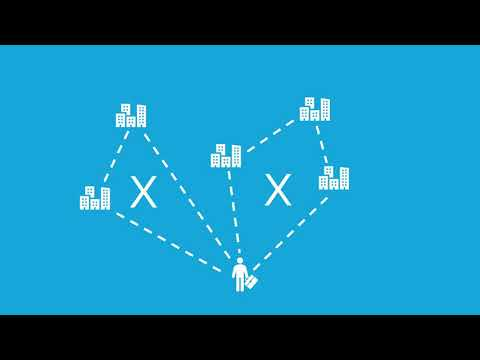

In [1]:
from IPython.display import Audio,Image, YouTubeVideo
id='1pmBjIZ20pE'
YouTubeVideo(id=id,width=600,height=300, start=0)